In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Thu Jan 18 04:17:41 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   36C    P0    44W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.prior.normal_prior import Prior
from model.latent.blse_latent import Latent
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [ ]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 3
hp.out_dim = 3
hp.z_dim = 128
hp.h_dims = [32, 64, 128, 256, 512]
hp.M = 1024
hp.N = 256
hp.const_sigma = False
hp.activation = F.sigmoid

''' Find Optimum Log-Sigma'''
from util.loglikelihood import get_optimum_log_sigma
from tqdm import tqdm

log_sigmas = []
for _ in tqdm(range(1000)):
    p_samples1 = torch.randn(hp.M, 1).cuda()
    p_samples2 = torch.randn(hp.N, 1).cuda()
    log_sigmas.append(get_optimum_log_sigma(p_samples1, p_samples2, min_log_sigma=-10, max_log_sigma=10, temperature=1))
optimum_log_sigma = np.median(log_sigmas)
print(optimum_log_sigma)

hp.init_log_sigma = optimum_log_sigma

 35%|██████████████                          | 351/1000 [00:09<00:15, 42.57it/s]

In [ ]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

### Load

In [ ]:
save_dir = '/data/scpark/save/lse/train_celeba/train01.17-8/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, models, opt_g = load(save_dir, 0, models, optimizer)

### Dataset

In [ ]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

test_transforms = transforms.Compose([transforms.CenterCrop(148),
                                      transforms.Resize(hp.size),
                                      transforms.ToTensor(),])
test_dataset = MyCelebA(root, split='test', transform=test_transforms, download=False)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False)
print('done')

### Preprocess

In [ ]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [ ]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

tensor([0.9919], device='cuda:0', grad_fn=<ExpBackward0>)


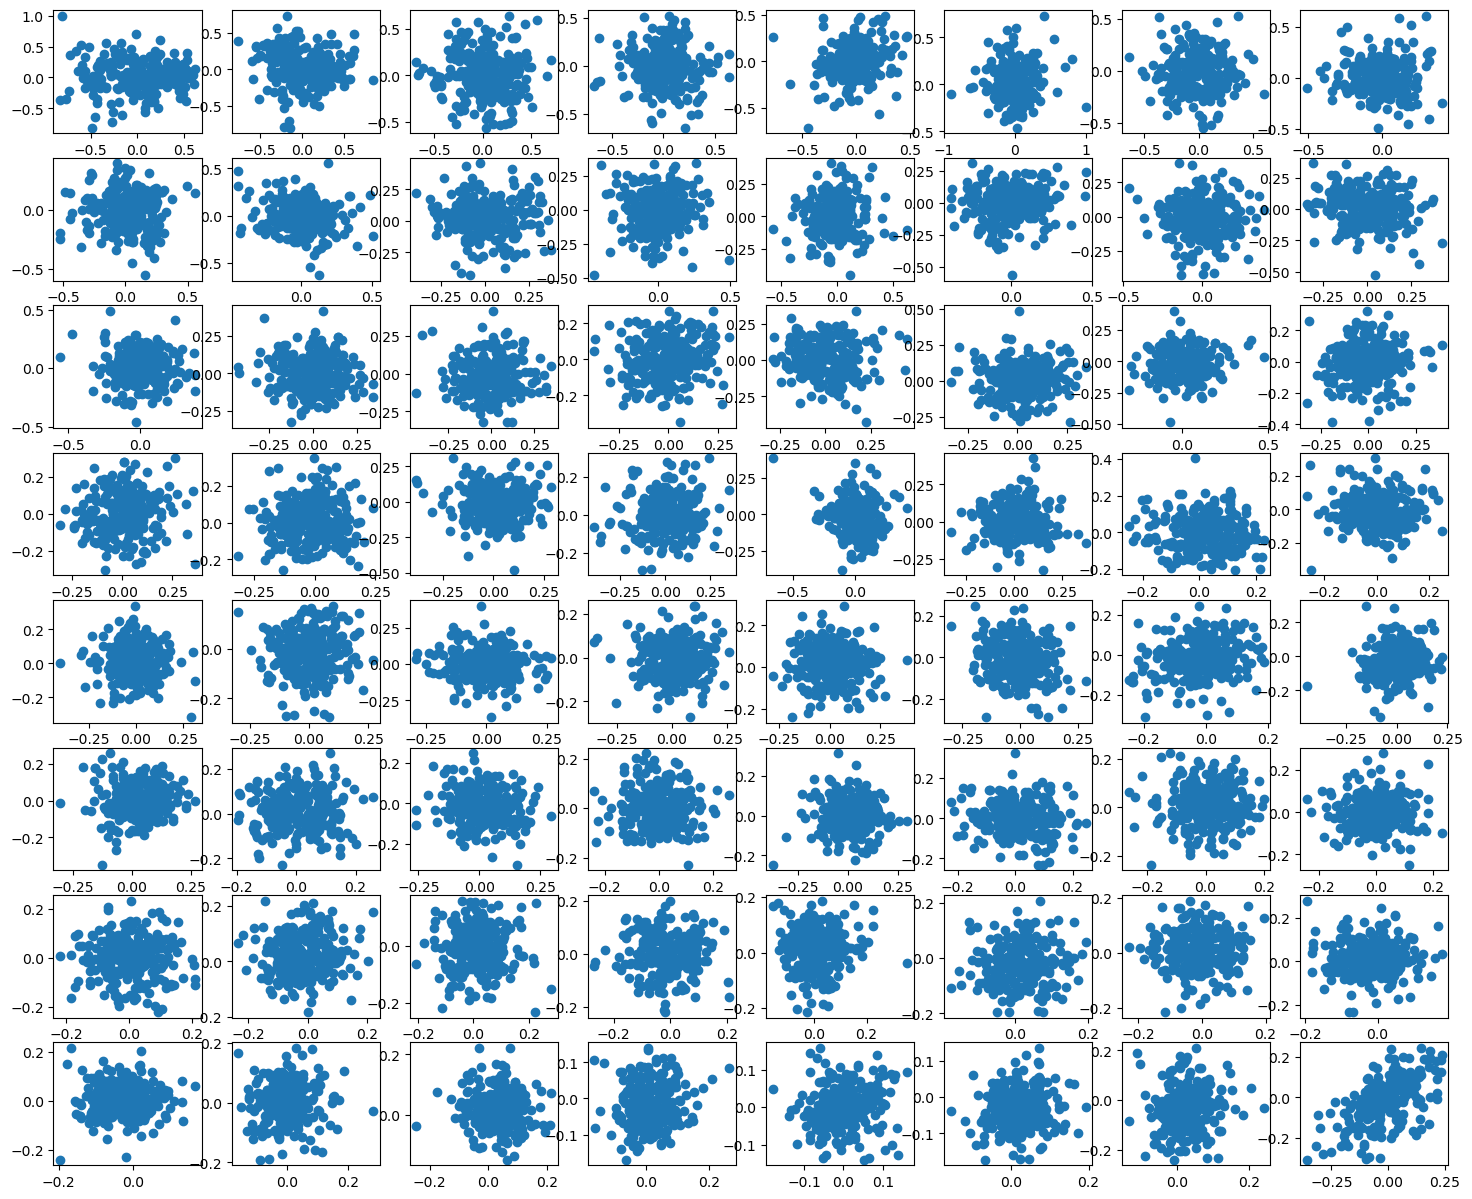

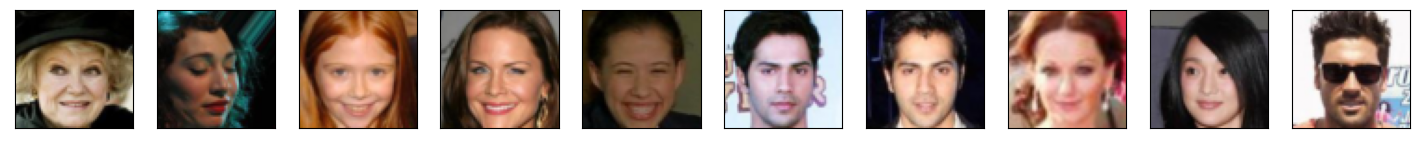

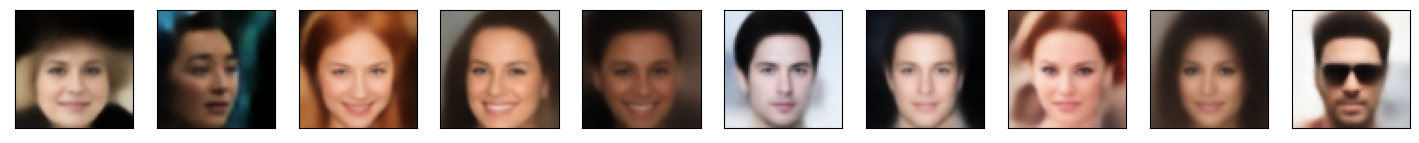

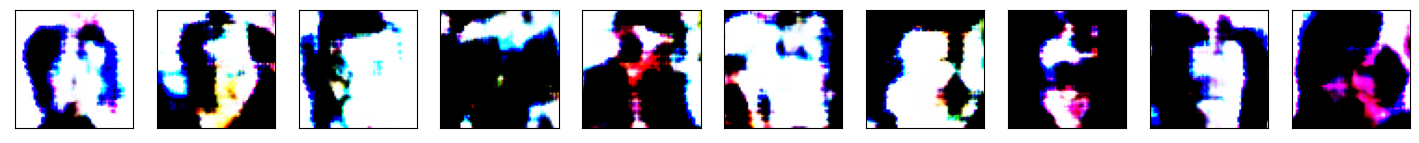

127001
lse_loss -0.003716416656970978
recon_loss 0.00842768233269453
127002
lse_loss -0.0010557584464550018
recon_loss 0.009798235259950161
127003
lse_loss -0.0009026303887367249
recon_loss 0.009038617834448814
127004
lse_loss 0.0034278593957424164
recon_loss 0.007510807365179062
127005
lse_loss -0.00014585629105567932
recon_loss 0.009090889245271683
127006
lse_loss 8.799508213996887e-05
recon_loss 0.008745620958507061
127007
lse_loss 0.000378679484128952
recon_loss 0.007910653948783875
127008
lse_loss -0.002446230500936508
recon_loss 0.008703900501132011
127009
lse_loss 0.0015550889074802399
recon_loss 0.008546180091798306
127010
lse_loss 0.0006376840174198151
recon_loss 0.00942305475473404
127011
lse_loss 0.0005946718156337738
recon_loss 0.008343932218849659
127012
lse_loss -0.001797553151845932
recon_loss 0.007534988224506378
127013
lse_loss -0.002186909317970276
recon_loss 0.008777841925621033
127014
lse_loss 0.00010194256901741028
recon_loss 0.009303892962634563
127015
lse_loss 0.

127118
lse_loss -0.0018907934427261353
recon_loss 0.010272732004523277
127119
lse_loss 0.0002469196915626526
recon_loss 0.00906641036272049
127120
lse_loss -0.0010805167257785797
recon_loss 0.008381707593798637
127121
lse_loss -0.00064115971326828
recon_loss 0.008077850565314293
127122
lse_loss -0.003958296030759811
recon_loss 0.00800652801990509
127123
lse_loss 0.0011378638446331024
recon_loss 0.008515119552612305
127124
lse_loss -0.0010552145540714264
recon_loss 0.008738115429878235
127125
lse_loss -0.001010250300168991
recon_loss 0.008304242976009846
127126
lse_loss 0.00333520770072937
recon_loss 0.008489497005939484
127127
lse_loss -0.0010963380336761475
recon_loss 0.008602079004049301
127128
lse_loss 0.0013970397412776947
recon_loss 0.007842661812901497
127129
lse_loss -0.0014149472117424011
recon_loss 0.009178180247545242
127130
lse_loss -0.0012079030275344849
recon_loss 0.009007195010781288
127131
lse_loss 0.001141529530286789
recon_loss 0.008133500814437866
127132
lse_loss 4.43

127235
lse_loss -0.002652432769536972
recon_loss 0.008395753800868988
127236
lse_loss 0.0007958188652992249
recon_loss 0.008219022303819656
127237
lse_loss -0.00061802938580513
recon_loss 0.008584771305322647
127238
lse_loss -0.0003582686185836792
recon_loss 0.006794921588152647
127239
lse_loss 0.0018305592238903046
recon_loss 0.008586843498051167
127240
lse_loss 0.003916870802640915
recon_loss 0.007897904142737389
127241
lse_loss 0.003767244517803192
recon_loss 0.0085601806640625
127242
lse_loss -0.0027420297265052795
recon_loss 0.01028984785079956
127243
lse_loss 8.933618664741516e-05
recon_loss 0.008254814893007278
127244
lse_loss 0.0012440197169780731
recon_loss 0.008354032412171364
127245
lse_loss 0.001020636409521103
recon_loss 0.007286418229341507
127246
lse_loss 0.0033423975110054016
recon_loss 0.008013620972633362
127247
lse_loss -0.001480981707572937
recon_loss 0.008593359030783176
127248
lse_loss 0.0017843097448349
recon_loss 0.00841609202325344
127249
lse_loss 0.00070025399

127352
lse_loss -0.0006840899586677551
recon_loss 0.008006542921066284
127353
lse_loss -0.0008677281439304352
recon_loss 0.00953621231019497
127354
lse_loss 0.0006055682897567749
recon_loss 0.007839445024728775
127355
lse_loss -0.0018086768686771393
recon_loss 0.009549654088914394
127356
lse_loss 0.001184910535812378
recon_loss 0.007935404777526855
127357
lse_loss 0.0007069706916809082
recon_loss 0.008564445190131664
127358
lse_loss 0.000431843101978302
recon_loss 0.009693315252661705
127359
lse_loss -0.0015634559094905853
recon_loss 0.008898889645934105
127360
lse_loss -0.000563550740480423
recon_loss 0.008598115295171738
127361
lse_loss 0.0006505586206912994
recon_loss 0.008091986179351807
127362
lse_loss 0.004127465188503265
recon_loss 0.007820505648851395
127363
lse_loss -0.00034430623054504395
recon_loss 0.008704625070095062
127364
lse_loss 0.004016038030385971
recon_loss 0.008476249873638153
127365
lse_loss 0.00332082062959671
recon_loss 0.00825594738125801
127366
lse_loss 0.0005

127470
lse_loss -0.0010491609573364258
recon_loss 0.007776725571602583
127471
lse_loss -0.0007977969944477081
recon_loss 0.007595806382596493
127472
lse_loss 5.7034194469451904e-06
recon_loss 0.009103445336222649
127473
lse_loss 0.0018347091972827911
recon_loss 0.009137424640357494
127474
lse_loss -0.0035928748548030853
recon_loss 0.007455652114003897
127475
lse_loss 0.0025193430483341217
recon_loss 0.007388441823422909
127476
lse_loss 0.002365410327911377
recon_loss 0.008328817784786224
127477
lse_loss 0.00015277042984962463
recon_loss 0.009275803342461586
127478
lse_loss 0.0018444918096065521
recon_loss 0.008947202935814857
127479
lse_loss 0.0029698610305786133
recon_loss 0.008813020773231983
127480
lse_loss -0.0009577646851539612
recon_loss 0.009559559635818005
127481
lse_loss 0.0009971223771572113
recon_loss 0.008210473693907261
127482
lse_loss 0.0025344565510749817
recon_loss 0.008910243399441242
127483
lse_loss 0.0002028048038482666
recon_loss 0.00795302540063858
127484
lse_loss 

127587
lse_loss -0.0013630986213684082
recon_loss 0.009621193632483482
127588
lse_loss -0.0019349083304405212
recon_loss 0.00794986356049776
127589
lse_loss 0.0002212338149547577
recon_loss 0.008638855069875717
127590
lse_loss 0.002747669816017151
recon_loss 0.007919307798147202
127591
lse_loss -0.0013606995344161987
recon_loss 0.008960694074630737
127592
lse_loss -0.0012494996190071106
recon_loss 0.00917659979313612
127593
lse_loss 0.000476103276014328
recon_loss 0.008401437662541866
127594
lse_loss 0.0010784156620502472
recon_loss 0.008419475518167019
127595
lse_loss 0.0009093396365642548
recon_loss 0.00942601915448904
127596
lse_loss 0.002407517284154892
recon_loss 0.008786647580564022
127597
lse_loss -0.0004206821322441101
recon_loss 0.008036908693611622
127598
lse_loss -0.001782238483428955
recon_loss 0.007999471388757229
127599
lse_loss -0.003620930016040802
recon_loss 0.007406690623611212
127600
lse_loss -0.002331312745809555
recon_loss 0.008878877386450768
127601
lse_loss 0.000

127705
lse_loss 0.001665320247411728
recon_loss 0.00835760124027729
127706
lse_loss 0.0024972856044769287
recon_loss 0.007770668715238571
127707
lse_loss -0.0014038197696208954
recon_loss 0.0071919262409210205
127708
lse_loss 0.00483902171254158
recon_loss 0.007681849412620068
127709
lse_loss 0.0010789111256599426
recon_loss 0.007493650075048208
127710
lse_loss -0.0011680014431476593
recon_loss 0.008171173743903637
127711
lse_loss 0.0003683827817440033
recon_loss 0.00791485607624054
127712
lse_loss 0.00012543052434921265
recon_loss 0.009277977980673313
127713
lse_loss -0.0003831498324871063
recon_loss 0.008443344384431839
127714
lse_loss 0.0005498602986335754
recon_loss 0.008410400710999966
127715
lse_loss -0.0007987767457962036
recon_loss 0.007795463316142559
127716
lse_loss 0.002774018794298172
recon_loss 0.009695865213871002
127717
lse_loss -0.0035300850868225098
recon_loss 0.008746638894081116
127718
lse_loss -0.004413854330778122
recon_loss 0.007826081477105618
127719
lse_loss 0.0

127822
lse_loss -0.0031280741095542908
recon_loss 0.009476352483034134
127823
lse_loss -0.0007675252854824066
recon_loss 0.008457586169242859
127824
lse_loss 0.0011153630912303925
recon_loss 0.008409908972680569
127825
lse_loss -0.00012839585542678833
recon_loss 0.008868133649230003
127826
lse_loss -0.001159418374300003
recon_loss 0.008945140056312084
127827
lse_loss -0.0012535527348518372
recon_loss 0.008748453110456467
127828
lse_loss -0.0006168261170387268
recon_loss 0.00841344241052866
127829
lse_loss 0.0009735971689224243
recon_loss 0.008280221372842789
127830
lse_loss 4.082918167114258e-06
recon_loss 0.00871522817760706
127831
lse_loss 0.002339240163564682
recon_loss 0.00866925623267889
127832
lse_loss 0.0011242926120758057
recon_loss 0.008471931330859661
127833
lse_loss -0.0009753145277500153
recon_loss 0.007799617014825344
127834
lse_loss 0.003172706812620163
recon_loss 0.007376363035291433
127835
lse_loss -0.0008735321462154388
recon_loss 0.007559142541140318
127836
lse_loss 0

127939
lse_loss 0.0017339028418064117
recon_loss 0.00875894445925951
127940
lse_loss -0.0005244649946689606
recon_loss 0.008538536727428436
127941
lse_loss 0.0021539069712162018
recon_loss 0.007789073046296835
127942
lse_loss 0.002919483929872513
recon_loss 0.009310957044363022
127943
lse_loss 0.0009077377617359161
recon_loss 0.0071189263835549355
127944
lse_loss 0.0005416050553321838
recon_loss 0.008808378130197525
127945
lse_loss -0.0005329437553882599
recon_loss 0.008568836376070976
127946
lse_loss 0.0006467774510383606
recon_loss 0.0069610727950930595
127947
lse_loss 0.0037040673196315765
recon_loss 0.009858427569270134
127948
lse_loss -0.0010728947818279266
recon_loss 0.00803731195628643
127949
lse_loss 0.0033931322395801544
recon_loss 0.007847311906516552
127950
lse_loss -0.0013037659227848053
recon_loss 0.007742471527308226
127951
lse_loss 0.004242278635501862
recon_loss 0.008252864703536034
127952
lse_loss 0.0006816498935222626
recon_loss 0.008099518716335297
127953
lse_loss 0.

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



128102
lse_loss -0.0011677667498588562
recon_loss 0.008297966793179512
128103
lse_loss 0.0021696090698242188
recon_loss 0.009500519372522831
128104
lse_loss -0.002324070781469345
recon_loss 0.009089420549571514
128105
lse_loss 0.002053331583738327
recon_loss 0.008480885997414589
128106
lse_loss -0.0008035190403461456
recon_loss 0.009941603988409042
128107
lse_loss -0.0008971281349658966
recon_loss 0.008734101429581642
128108
lse_loss 0.0028629079461097717
recon_loss 0.010361210443079472
128109
lse_loss -0.0013494528830051422
recon_loss 0.008621330372989178
128110
lse_loss -0.0011052638292312622
recon_loss 0.008540624752640724
128111
lse_loss -0.0021165870130062103
recon_loss 0.0090567572042346
128112
lse_loss -0.0006890706717967987
recon_loss 0.0080876424908638
128113
lse_loss 0.0021064579486846924
recon_loss 0.00941427145153284
128114
lse_loss 0.0022000670433044434
recon_loss 0.008306114934384823
128115
lse_loss 0.0007780157029628754
recon_loss 0.009151793085038662
128116
lse_loss 0.0

128219
lse_loss -0.0016933903098106384
recon_loss 0.009471144527196884
128220
lse_loss -0.001550275832414627
recon_loss 0.00926272664219141
128221
lse_loss 0.002186555415391922
recon_loss 0.009587125852704048
128222
lse_loss 0.0010500140488147736
recon_loss 0.008191927336156368
128223
lse_loss 0.002862166613340378
recon_loss 0.008264086209237576
128224
lse_loss -0.00015826895833015442
recon_loss 0.009368966333568096
128225
lse_loss 0.0015943646430969238
recon_loss 0.008356645703315735
128226
lse_loss -0.003273971378803253
recon_loss 0.008989773690700531
128227
lse_loss -0.00122002512216568
recon_loss 0.007746242918074131
128228
lse_loss 0.00196930393576622
recon_loss 0.008062684908509254
128229
lse_loss -0.005127478390932083
recon_loss 0.00874200277030468
128230
lse_loss -0.002439882606267929
recon_loss 0.008822953328490257
128231
lse_loss -0.0008705742657184601
recon_loss 0.00879254937171936
128232
lse_loss -4.559755325317383e-06
recon_loss 0.008590064942836761
128233
lse_loss -0.0003

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, M=hp.M, temperature=1)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key] * 0.1
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            print(torch.exp(model_list[0].latent.log_sigma))
            
            z = data['z_copy'].data.cpu().numpy()
            plt.figure(figsize=[18, 15])
            for i in range(64):
                plt.subplot(8, 8, i+1)
                plt.scatter(z[:, 2*i], z[:, 2*i+1])
            plt.show()
        
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model = model_list[0]
            model.eval()
            with torch.no_grad():
                data = model(data, M=hp.M)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = model.prior.sample(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [11]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

done
